In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

train_data = pd.read_csv('/content/Reg_Train.txt', sep=' ', header=None)
test_data = pd.read_csv('/content/Reg_Test.txt', sep=' ', header=None)

x_scaler.fit(train_data.iloc[:, :-1].values.astype(np.float32))
y_scaler.fit(pd.DataFrame(train_data.iloc[:, -1].values.astype(np.float32)))

batch_size = 128

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, x_scaler, y_scaler):
        self.data = data
        self.x = data.iloc[:, :-1].values.astype(np.float32)
        self.x = x_scaler.transform(self.x)
        self.y = pd.DataFrame(data.iloc[:, -1].values.astype(np.float32))
        self.y = y_scaler.transform(self.y)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = CustomDataset(train_data, x_scaler, y_scaler)
test_dataset = CustomDataset(test_data, x_scaler, y_scaler)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

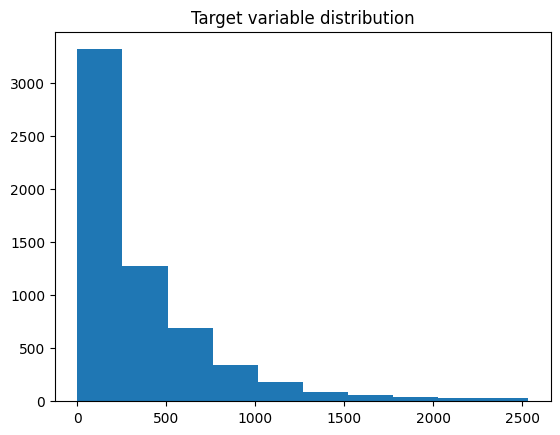

In [ ]:
plt.hist(train_data.iloc[:, -1])
plt.title('Target variable distribution')
plt.show()

In [ ]:
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000,6046.000000
mean,0.349983,0.456335,0.302232,0.532087,0.362058,0.338902,0.279193,0.632153,0.341259,0.450367,0.281917,184.199471,0.306615,0.587937,0.132070,0.134000,0.135480,0.359196,347.369831
std,0.267098,0.498131,0.182641,0.499011,0.480635,0.473376,0.448640,0.482259,0.305542,0.212988,0.215533,62.642887,0.252289,0.164892,0.158133,0.157609,0.157418,0.210961,413.654221
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.126100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230800,0.097500,142.000000,0.062600,0.483900,0.017300,0.017700,0.017700,0.176800,48.000000
50%,0.333300,0.000000,0.277300,1.000000,0.000000,0.000000,0.000000,1.000000,0.250000,0.461500,0.238300,197.000000,0.245900,0.580600,0.081600,0.083400,0.085300,0.340600,214.000000
75%,0.666700,1.000000,0.445400,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.615400,0.426000,236.000000,0.480600,0.677400,0.186600,0.191000,0.192900,0.539400,488.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.891700,270.000000,0.970800,1.000000,0.993300,1.000000,1.000000,0.759000,2533.000000


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device = "cpu"
print(f"Using {device} device")

input_size = train_dataset.x.shape[1]
output_size = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 72),
            nn.Sigmoid(),
            # nn.Dropout(0.2),
            nn.Linear(72, 36),
            nn.Sigmoid(),
            # nn.Dropout(0.2),
            # nn.Linear(36, 18),
            # nn.Sigmoid(),
            # nn.Dropout(0.1),
            nn.Linear(36, output_size),
        )


    def forward(self, x):
        predictions = self.linear_relu_stack(x)
        return predictions

torch.manual_seed(42)
model = NeuralNetwork(input_size=input_size, output_size=output_size).to(device)
print(model)

Using cpu device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=18, out_features=72, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=72, out_features=36, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=36, out_features=1, bias=True)
  )
)


In [ ]:
from torchsummary import summary

summary(model, (1,18))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 72]           1,368
           Sigmoid-2                [-1, 1, 72]               0
            Linear-3                [-1, 1, 36]           2,628
           Sigmoid-4                [-1, 1, 36]               0
            Linear-5                 [-1, 1, 1]              37
Total params: 4,033
Trainable params: 4,033
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [ ]:
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 400

In [ ]:
loss_fn = nn.MSELoss()

In [ ]:
import copy

#create a function for a train loop and a test loop for train data and test data respectively
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    tot_loss = 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        #compute prediction and loss
        pred = model(X)
        y = y.view(pred.shape)
        loss = loss_fn(pred, y)

        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tot_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

    return tot_loss/len(dataloader)

best_mse = np.inf
best_weights = None

unscaled_losses = []

#test loop
def test_loop(dataloader, model, loss_fn, best_mse, best_weights):
    num_batches = len(dataloader)
    test_loss= 0
    unscaled_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = y.view(pred.shape)
            real_unscaled = torch.from_numpy(y_scaler.inverse_transform(y).reshape(y.shape))
            pred_unscaled = torch.from_numpy(y_scaler.inverse_transform(pred).reshape(pred.shape))
            unscaled_loss += loss_fn(pred_unscaled, real_unscaled).item()
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    unscaled_losses.append(unscaled_loss / num_batches)
    if test_loss < best_mse:
      best_mse = test_loss
      best_weights = copy.deepcopy(model.state_dict())
    print(f"Test Error: \n Avg loss: {test_loss:>8f} Avg RMSE: {np.sqrt(test_loss):>8f} \n")
    return test_loss, best_mse, best_weights

In [ ]:
def plot_loss(train_losses=None, test_losses=None):
    plt.figure(figsize=(8, 6))
    if train_losses:
      plt.plot(train_losses, label="Training Loss")
    if test_losses:
      plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Epoch 1
-------------------------------
loss: 0.022240 [    0/ 6046]
loss: 0.015188 [ 1280/ 6046]
loss: 0.031741 [ 2560/ 6046]
loss: 0.032196 [ 3840/ 6046]
loss: 0.025546 [ 5120/ 6046]
Test Error: 
 Avg loss: 0.067350 Avg RMSE: 0.259518 

Epoch 2
-------------------------------
loss: 0.024428 [    0/ 6046]
loss: 0.039798 [ 1280/ 6046]
loss: 0.023308 [ 2560/ 6046]
loss: 0.023991 [ 3840/ 6046]
loss: 0.024896 [ 5120/ 6046]
Test Error: 
 Avg loss: 0.066126 Avg RMSE: 0.257149 

Epoch 3
-------------------------------
loss: 0.029219 [    0/ 6046]
loss: 0.025953 [ 1280/ 6046]
loss: 0.028160 [ 2560/ 6046]
loss: 0.020330 [ 3840/ 6046]
loss: 0.025696 [ 5120/ 6046]
Test Error: 
 Avg loss: 0.065127 Avg RMSE: 0.255201 

Epoch 4
-------------------------------
loss: 0.028651 [    0/ 6046]
loss: 0.024004 [ 1280/ 6046]
loss: 0.048388 [ 2560/ 6046]
loss: 0.028176 [ 3840/ 6046]
loss: 0.021351 [ 5120/ 6046]
Test Error: 
 Avg loss: 0.062516 Avg RMSE: 0.250033 

Epoch 5
-------------------------------
loss

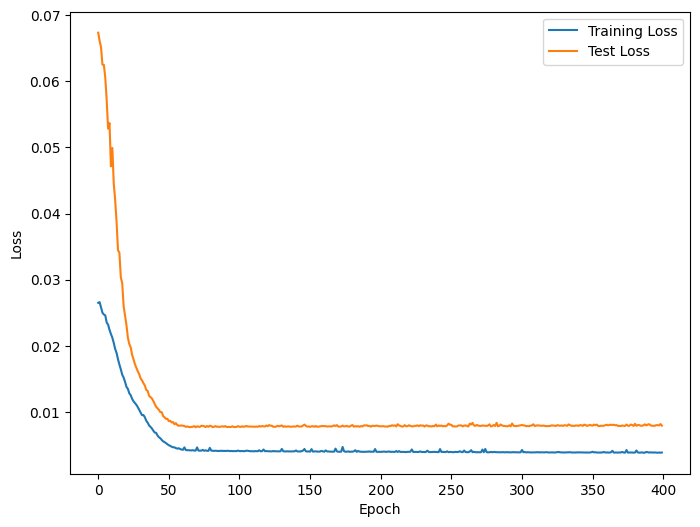

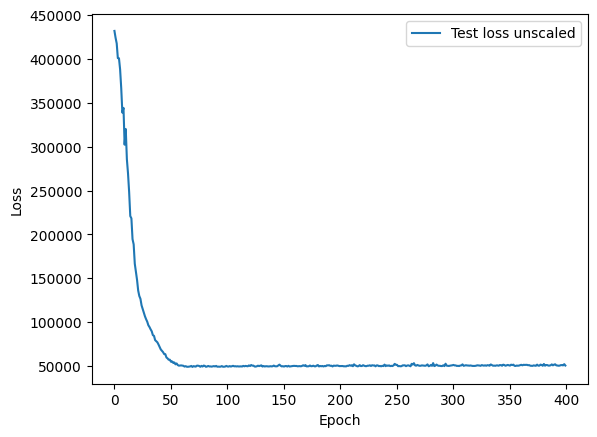

Best loss: 0.007678 Best RMSE: 0.087626
Best unscaled loss: 49226.277855601555 Best RMSE: 221.86995708207445


In [ ]:
train_losses, test_losses = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    # scheduler.step()
    test_loss, best_mse, best_weights = test_loop(test_loader, model, loss_fn, best_mse, best_weights)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

plot_loss(train_losses, test_losses)
plt.plot(unscaled_losses, label="Test loss unscaled")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
print(f"Best loss: {best_mse:>8f} Best RMSE: {np.sqrt(best_mse):>8f}")
print(f"Best unscaled loss: {min(unscaled_losses)} Best RMSE: {np.sqrt(min(unscaled_losses))}")

Average MSE of the best model: 0.007678 Standard deviation of MSE of the best model 0.004829
Unscaled Average MSE of the best model: 49226.277856 Unscaled Standard deviation of MSE of the best model 30956.704846


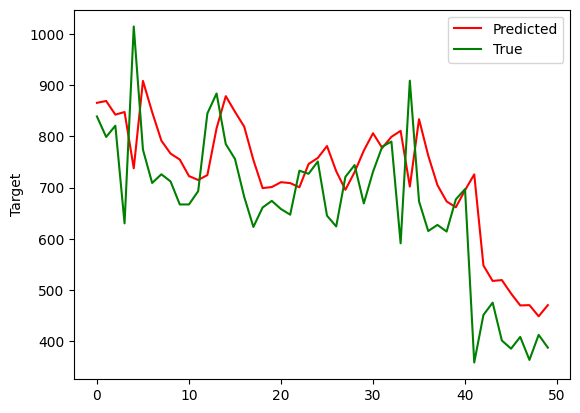

In [ ]:
model.load_state_dict(best_weights)

model.eval()
unscaled_losses = []
losses = []

predictions, real_y = np.array([]), np.array([])
with torch.no_grad():
    for inputs, outputs in test_loader:
        inputs = inputs.to(device)
        pred = model(inputs)
        outputs = outputs.view(pred.shape)

        outputs_unscaled = torch.from_numpy(y_scaler.inverse_transform(outputs))
        pred_unscaled = torch.from_numpy(y_scaler.inverse_transform(pred))
        real_y = np.concatenate((real_y, outputs_unscaled.numpy().flatten()))
        predictions = np.concatenate((predictions, pred_unscaled.numpy().flatten()))
        loss = loss_fn(pred, outputs).item()
        unscaled_losses.append(loss_fn(pred_unscaled, outputs_unscaled).item())
        losses.append(loss)

losses = np.array(losses)
unscaled_losses = np.array(unscaled_losses)
print(f"Average MSE of the best model: {np.average(losses):>8f} Standard deviation of MSE of the best model {np.std(losses):>8f}")
print(f"Unscaled Average MSE of the best model: {np.average(unscaled_losses):>8f} Unscaled Standard deviation of MSE of the best model {np.std(unscaled_losses):>8f}")

plt.plot(predictions[:50], label="Predicted", c="red")
plt.plot(real_y[:50], label="True", c="green")
plt.legend()
plt.ylabel("Target")
plt.show()

In [ ]:
root_losses = np.array(list(map(lambda x: np.sqrt(x), losses)))
unscaled_root_losses = np.array(list(map(lambda x: np.sqrt(x), unscaled_losses)))
print(f"Average RMSE: {np.average(root_losses):>8f} Standard deviation: {np.std(root_losses):>8f}")
print(f"Average RMSE: {np.average(unscaled_root_losses):>8f} Standard deviation: {np.std(unscaled_root_losses):>8f}")

Average RMSE: 0.083164 Standard deviation: 0.027607
Average RMSE: 210.571239 Standard deviation: 69.900152
